In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/boston-map-hd/map.png
/kaggle/input/boston/calendar.csv
/kaggle/input/boston/listings.csv
/kaggle/input/boston/reviews.csv
/kaggle/input/boston-map/Boston.PNG


# ***Business Understanding***



1.) What are the features that influence the property pricing?

2.) Do Superhosts perform better than other hosts?

3.) Create a model to predict property pricing


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#read the csv file
df_list = pd.read_csv("/kaggle/input/boston/listings.csv")
df_cal = pd.read_csv("/kaggle/input/boston/calendar.csv")

for data in [df_list, df_cal]:
    print(data.shape)

(3585, 95)
(1308890, 4)


In [4]:
for data in [df_list, df_cal]:
    display(data.head(5))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


# Data preprocess for Listing dataset (df_list)

In [5]:
#check for the each column's datatype and the number of non-null values in the data set.
#this helps to understand features better and their contribution for the further data preparation.
df_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [6]:
#Remove the column which has all values as NaN
df_list.dropna(axis = 1, how = 'all', inplace = True)
df_list.shape

(3585, 91)

* In order to analyse the property size, we need to consider the **property type, room type, and bedrooms** feature from the data set.

* We will further explore the above said feature and create a new dataframe.

In [7]:
#drop na rows in bathrooms, bedrooms, beds
df_list.dropna(axis = 0, subset = ["bathrooms", "bedrooms", "beds"], inplace = True)

#Creating new dataframe with bathrooms, bedrooms, beds
df_rooms = df_list[["bathrooms", "bedrooms", "beds"]]

#Converting the data type from string to integer
for room in df_rooms:
    df_rooms[room].astype(int)
    
#Assigning the converted values from df_rooms to the df_list data frame
df_list[["bathrooms", "bedrooms", "beds"]] = df_rooms[["bathrooms", "bedrooms", "beds"]]

In [8]:
#replace $ from the price values and convert str into float data type
for feature in ["cleaning_fee", "security_deposit", "price"]:
    df_list[feature] = df_list[feature].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore')
    df_list[feature] = df_list[feature].astype(float)
    df_list[feature].fillna(df_list[feature].median(), inplace = True)
    
    
    
# fill na with median values for reviews columns
for feature in ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value", "reviews_per_month"]:
    df_list[feature].fillna(df_list[feature].median(), inplace = True)

In [9]:
#Create new dataframe selecting only the numerical columns
df_int = df_list.select_dtypes(include=['int64', 'float64'])

#add categorical columns to df_int
df_int[['superhost', 'room_type', 'neighbourhood_cleansed', 'cancellation_policy', 'property_type']] = df_list[['host_is_superhost', 
                                                                             'room_type', 
                                                                             'neighbourhood_cleansed', 'cancellation_policy', 'property_type']]

#drop the columns which has large number of null values, which will be a hinder while applying prediction algorithms
df_int.drop(labels = ["square_feet"], axis = 1, inplace = True)
df_int.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557 entries, 0 to 3584
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3557 non-null   int64  
 1   scrape_id                       3557 non-null   int64  
 2   host_id                         3557 non-null   int64  
 3   host_listings_count             3557 non-null   int64  
 4   host_total_listings_count       3557 non-null   int64  
 5   latitude                        3557 non-null   float64
 6   longitude                       3557 non-null   float64
 7   accommodates                    3557 non-null   int64  
 8   bathrooms                       3557 non-null   float64
 9   bedrooms                        3557 non-null   float64
 10  beds                            3557 non-null   float64
 11  price                           3557 non-null   float64
 12  security_deposit                35

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Data Preprocessing for Calendar data - df_cal

In [10]:
#Extract month from dates column
df_cal['month'] = df_cal.date.apply(lambda value: value.split('-')[1])
df_cal['month'] = df_cal['month'].replace({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

#Remove special character $ from price column and convert to float
df_cal.dropna(axis = 0, subset = ["price"], inplace = True)
df_cal["price"] = df_cal["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore').astype(float)

df_cal.head()


,listing_id,date,available,price,month
365,3075044,2017-08-22,t,65.0,Aug
366,3075044,2017-08-21,t,65.0,Aug
367,3075044,2017-08-20,t,65.0,Aug
368,3075044,2017-08-19,t,75.0,Aug
369,3075044,2017-08-18,t,75.0,Aug


# 1.) What are the features that influence the property pricing?

In [11]:
df_int.groupby(['room_type']).count()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,superhost,neighbourhood_cleansed,cancellation_policy,property_type
room_type,,,,,,,,,,,,,,,,,,,,,
Entire home/apt,2113,2113,2113,2113,2113,2113,2113,2113,2113,2113,...,2113,2113,2113,2113,2113,2113,2113,2113,2113,2111
Private room,1365,1365,1365,1365,1365,1365,1365,1365,1365,1365,...,1365,1365,1365,1365,1365,1365,1365,1365,1365,1364
Shared room,79,79,79,79,79,79,79,79,79,79,...,79,79,79,79,79,79,79,79,79,79


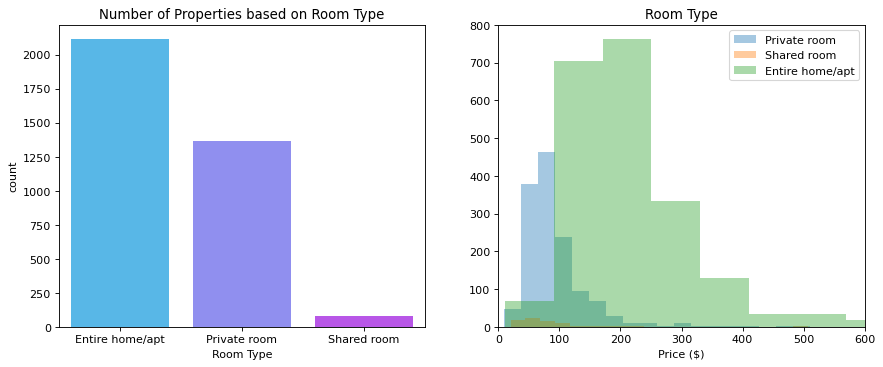

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), dpi=80)


sns.countplot(x = 'room_type', data = df_int, 
              palette = 'cool', ax=axs[0]).set_title("Number of Properties based on Room Type")
axs[0].set_xlabel('Room Type')




sns.distplot(df_int[df_int.room_type == 'Private room']['price'],
             kde=False, ax=axs[1], label='Private room')
sns.distplot(df_int[df_int.room_type == 'Shared room']['price'],
             kde=False, ax=axs[1], label='Shared room')
sns.distplot(df_int[df_int.room_type == 'Entire home/apt']['price'],
             kde=False, ax=axs[1], label='Entire home/apt')

axs[1].set_xlim(0, 600)
axs[1].set_title('Room Type')
axs[1].set_xlabel('Price ($)')
axs[1].legend()

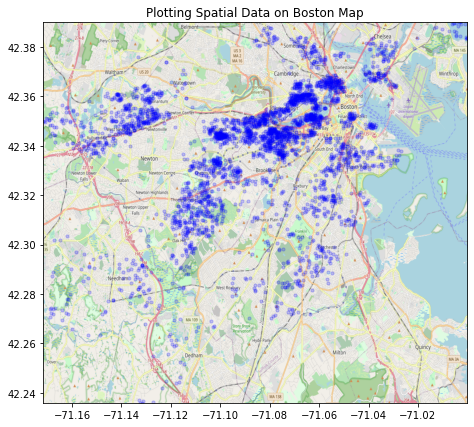

In [13]:
BBox = (df_int.longitude.min(), df_int.longitude.max(), df_int.latitude.min(), df_int.latitude.max())
BBox

ruh_m = plt.imread('/kaggle/input/boston-map-hd/map.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_int.longitude, df_int.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Boston Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

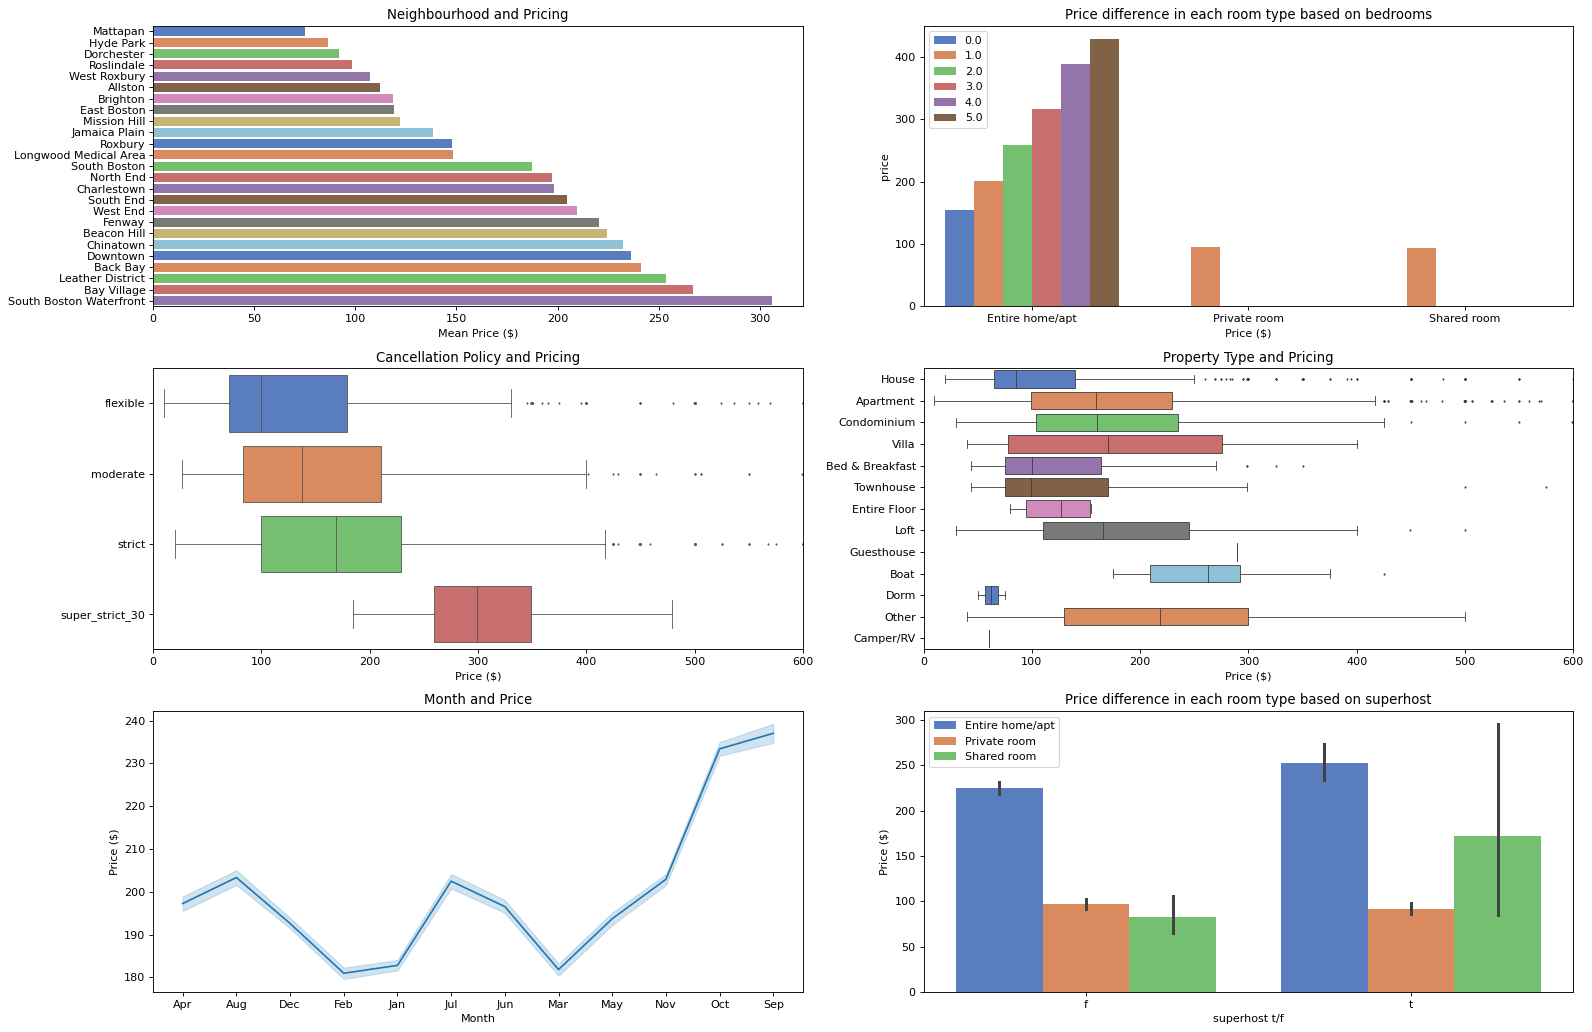

In [14]:
fig, axs = plt.subplots(3, 2, figsize=(20, 13), dpi=80)

df_roomtype = df_int.groupby(['room_type', 'bedrooms'], as_index = False).mean()

# Neighbourhoods
neighbourhoods = df_int.groupby('neighbourhood_cleansed').agg(
    {
        'price': np.mean
    }
).reset_index()
sns.barplot(
    x='price', y='neighbourhood_cleansed',
    data=neighbourhoods.sort_values('price'),
    orient='h',
    palette='muted',
    ax=axs[0, 0]
)
axs[0, 0].set_title('Neighbourhood and Pricing')
axs[0, 0].set_xlabel('Mean Price ($)')
axs[0, 0].set_ylabel('')

sns.barplot(x="room_type", y="price", hue= 'bedrooms', data= df_roomtype, 
            palette= 'muted', ax=axs[0, 1])

axs[0, 1].set_title('Price difference in each room type based on bedrooms')
axs[0, 1].set_xlabel('Price ($)')
axs[0, 1].legend()

# Cancellation Policy
sns.boxplot(x='price', y='cancellation_policy', fliersize=1, linewidth=0.75,
            data=df_int, palette='muted', ax=axs[1, 0],
            order=['flexible', 'moderate', 'strict', 'super_strict_30'])
axs[1, 0].set_xlim(0, 600)
axs[1, 0].set_title('Cancellation Policy and Pricing')
axs[1, 0].set_xlabel('Price ($)')
axs[1, 0].set_ylabel('')

# Property type
sns.boxplot(x='price', y='property_type', fliersize=1, linewidth=0.75,
            data=df_int, palette='muted', ax=axs[1, 1])
axs[1, 1].set_xlim(0, 600)
axs[1, 1].set_title('Property Type and Pricing')
axs[1, 1].set_xlabel('Price ($)')
axs[1, 1].set_ylabel('')


#calendar
sns.lineplot(data = df_cal, x = "month", y = "price", ax = axs[2,0])

axs[2, 0].set_title("Month and Price")
axs[2, 0].set_xlabel('Month')
axs[2, 0].set_ylabel('Price ($)')

#Superhost
sns.barplot(x="superhost", y="price", hue= 'room_type', data= df_int, 
            palette= 'muted', ax=axs[2, 1])

axs[2, 1].set_title('Price difference in each room type based on superhost')
axs[2, 1].set_xlabel('superhost t/f')
axs[2, 1].set_ylabel('Price ($)')
axs[2, 1].legend()


plt.tight_layout()
plt.show();



# 2.) Does Superhosts are performing well?


What is a Superhost?

Superhosts are experienced hosts who provide a shining example for other hosts, and extraordinary experiences for their guests.

Once a host reaches Superhost status, a badge superhost badge will automatically appear on their listing and profile to help you identify them.

We check Superhosts’ activity four times a year to ensure that the programme highlights the people who are most dedicated to providing outstanding hospitality.

In [15]:
#Average Review values for superhost listings
df_host_review = df_int.groupby(['superhost']).mean()

df_host_review[["number_of_reviews", "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
               "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value",
               "reviews_per_month"]]

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
superhost,,,,,,,,,
f,15.564444,92.080635,9.520952,9.377143,9.699683,9.701587,9.540635,9.062222,1.673298
t,44.941032,97.009828,9.906634,9.837838,9.953317,9.963145,9.626536,9.697789,2.830123


Text(0.5, 1.0, 'Average Review Score for Rooms with and without a Superhost')

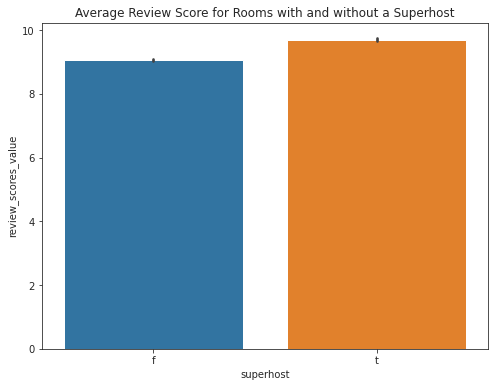

In [16]:
#Average Reveiw score value for a superhost
sns.set_style("ticks")
plt.figure(figsize=(8, 6))
sns.barplot(x = 'superhost', y = 'review_scores_value', data = df_int).set_title("Average Review Score for Rooms with and without a Superhost")

<Figure size 864x432 with 0 Axes>

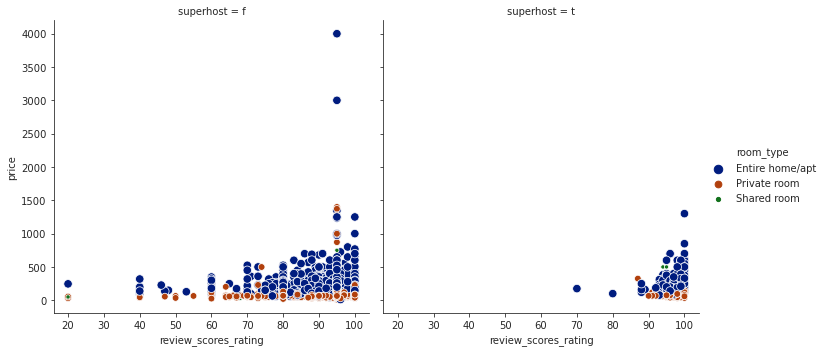

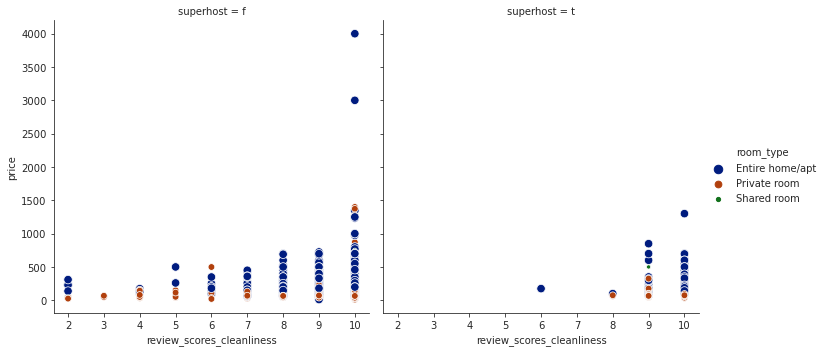

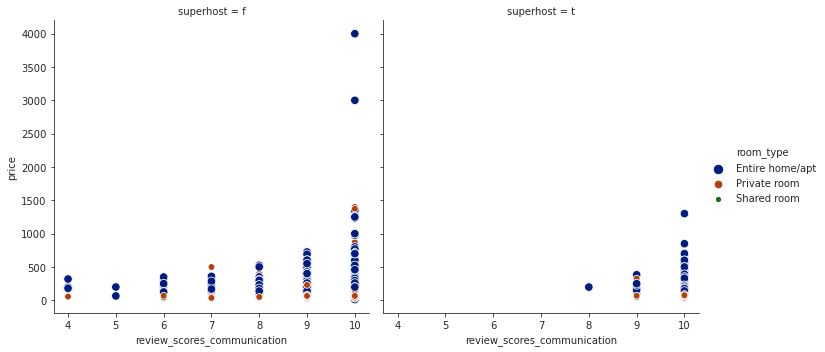

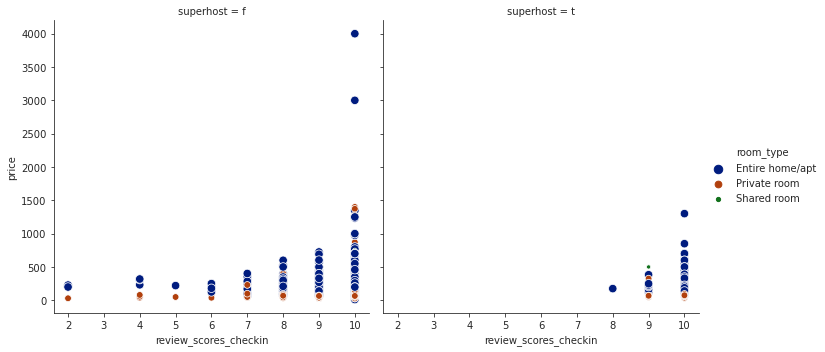

In [17]:
#Plot the review scores for superhost based on ratings, cleanliness, communication, check-in
sns.set_style("ticks")
plt.figure(figsize=(12, 6))

sns.relplot(x = 'review_scores_rating', y = 'price', data = df_int, kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = 'dark')

sns.relplot(x = 'review_scores_cleanliness', y = 'price', data = df_int, kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = 'dark')

sns.relplot(data=df_int, x= 'review_scores_communication', y="price", kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = "dark")

sns.relplot(data=df_int, x= 'review_scores_checkin', y="price", kind = "scatter", 
            col = "superhost", hue = "room_type", size = "room_type", palette = "dark")

# Model to predict property pricing

In [18]:
#Handle Categorical Variable

cleanup_nums = {"superhost":     {"t": 1, "f": 2},
                "room_type": {"Entire home/apt": 1, "Private room": 2, "Shared room": 3},
               "cancellation_policy": {"moderate": 1, "flexible": 2, "strict": 3, "super_strict_30": 4}}
df_int = df_int.replace(cleanup_nums)

#neighbourhood_cleansed, property_type
df_int_dummies = pd.get_dummies(df_int)

In [19]:
y = df_int_dummies.price
X = df_int_dummies.drop(labels = ["price"], axis = 1)

In [20]:
#import necessary libraries for performing prediction
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression


#split test and train dataset from X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

model_rf = RandomForestRegressor(n_estimators=100, random_state=0)

#Predict wth Random Forest Regressor
model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_test)

#Evaluate the model
print("MAE from Random Forest Regressor:") 
print(mean_absolute_error(y_test, preds_rf))

MAE from Random Forest Regressor:
46.709634831460676


Text(0, 0.5, 'Predictions ')

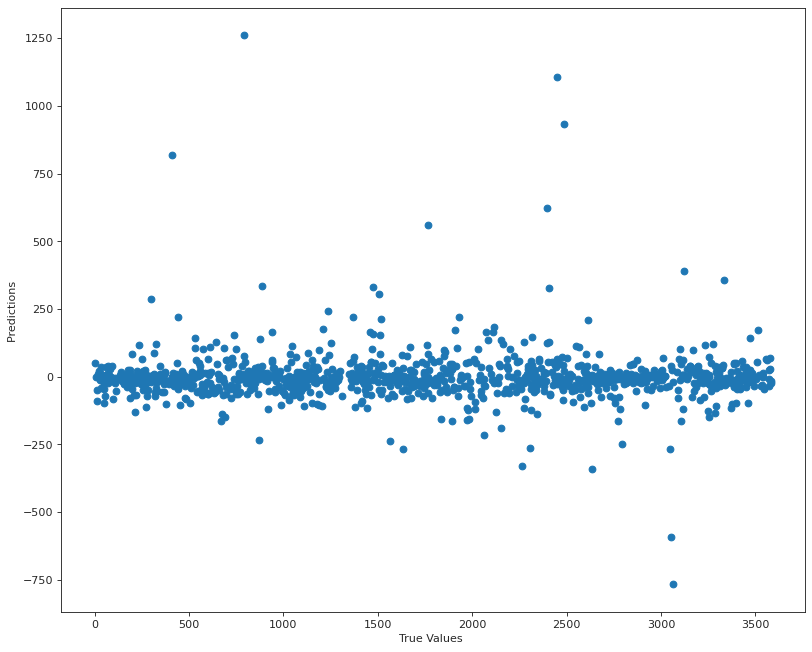

In [21]:
#Plot difference between actual value and predicted value - Random Forest Regressor

fig = plt.figure(figsize=(12, 10), dpi=80)
ax1 = fig.add_subplot(111)
lines = plt.plot(y_test - preds_rf,marker='o',linestyle='')
ax1.set_xlabel('True Values ')
ax1.set_ylabel('Predictions ')

In [22]:
#Predict wth Linear Regression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
preds_lr = model_lr.predict(X_test)

#Evaluate the model
print("MAE from Linear Regressor:") 
print(mean_absolute_error(y_test, preds_lr))

MAE from Linear Regressor:
171.42041198501872


Text(0, 0.5, 'Predictions ')

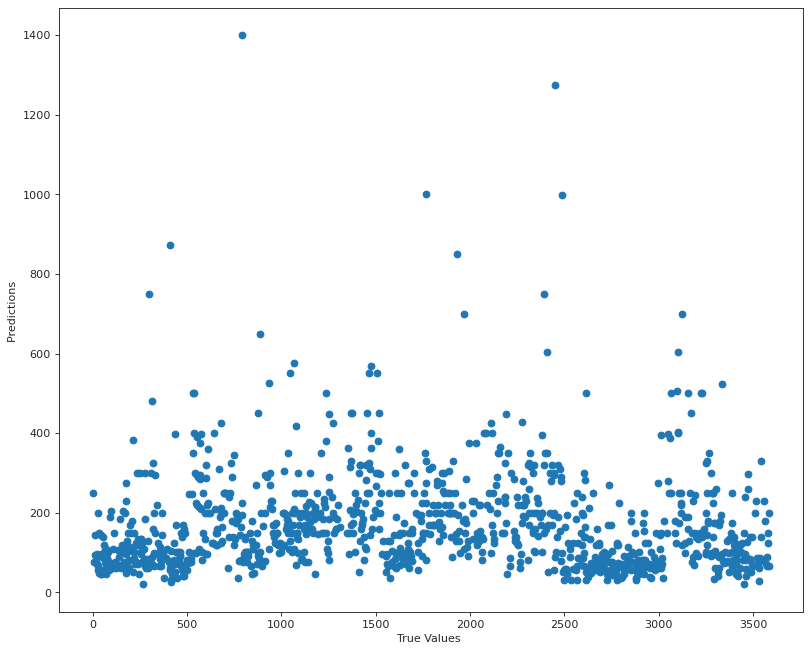

In [23]:
#Plot difference between actual value and predicted value - Linear Regression
fig = plt.figure(figsize=(12, 10), dpi=80)
ax1 = fig.add_subplot(111)
lines = plt.plot(y_test - preds_lr,marker='o',linestyle='')
ax1.set_xlabel('True Values ')
ax1.set_ylabel('Predictions ')